# Imports 

In [1]:
import tensorflow as tf
#Check GPU and CUDA Compatibility
print(tf.__version__)
print(tf.test.is_built_with_cuda())
print(tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None))

2.3.0
True
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img, save_img
from tensorflow.keras import losses
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model
import tensorflow_addons as tfa
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.utils import shuffle
%matplotlib notebook
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import glob
import itertools
from collections import defaultdict
import random
from tqdm.notebook import tqdm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from focal_loss import SparseCategoricalFocalLoss
import swifter

In [86]:
import plotly.graph_objs as go
import plotly.express as px
import plotly.io as pio
pio.templates.default = "plotly_dark"
from plotly.subplots import make_subplots

In [124]:
import joypy

In [43]:
import lightgbm as lgb

In [4]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 999)

# Data 

## Dataset Creation 

### Target based Train-Valid-Test Set Separation

In [3]:
key = pd.read_csv('D:/Storage/Datasets/skin_cancer_dataverse/HAM10000_metadata.csv')
key['dx'].value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

In [4]:
key.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    key['image_id'],
    key['dx'],
    test_size=0.10,
    random_state=420,
    stratify=key['dx']
)

In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train,
    y_train,
    test_size=0.10,
    random_state=420,
    stratify=y_train
)

In [7]:
y_train.value_counts()

nv       5430
mel       902
bkl       890
bcc       417
akiec     264
vasc      115
df         93
Name: dx, dtype: int64

In [8]:
y_valid.value_counts()

nv       604
mel      100
bkl       99
bcc       46
akiec     30
vasc      13
df        10
Name: dx, dtype: int64

In [9]:
y_test.value_counts()

nv       671
mel      111
bkl      110
bcc       51
akiec     33
vasc      14
df        12
Name: dx, dtype: int64

In [10]:
train_images = pd.concat([X_train,y_train], axis=1).reset_index(drop=True)
valid_images = pd.concat([X_valid,y_valid], axis=1).reset_index(drop=True)
test_images = pd.concat([X_test,y_test], axis=1).reset_index(drop=True)

### Loading in dirs 

In [74]:
def load_img(df, name):
    for i in tqdm(range(0, len(df))):
        path = "D:/Storage/Datasets/skin_cancer_dataverse/"
        shutil.copy(path + 'HAM10000_images/' + df['image_id'][i] + '.jpg',
                    path + 'dataset/' + name + '/' + df['dx'][i])

In [73]:
load_img(train_images, 'train_images')

In [75]:
load_img(valid_images, 'valid_images')

100%|███████████████████████████████████████████████████████████████████████████████| 902/902 [00:01<00:00, 819.62it/s]


In [76]:
load_img(test_images, 'test_images')

100%|█████████████████████████████████████████████████████████████████████████████| 1002/1002 [00:01<00:00, 814.04it/s]


## Investigating Image Properties 

In [92]:
# load the image
img = load_img(
    'D:/Storage/Datasets/skin_cancer_dataverse/dataset/train_images/nv/ISIC_0024307.jpg')
# report details about the image
print(type(img))
print(img.format)
print(img.mode)
print(img.size)
# show the image
img.show()

<class 'PIL.JpegImagePlugin.JpegImageFile'>
JPEG
RGB
(600, 450)


In [93]:
img_array = img_to_array(img)
print(img_array.shape)
print(img_array.dtype)

(450, 600, 3)
float32


In [94]:
img_array

array([[[213., 123., 135.],
        [215., 122., 133.],
        [219., 123., 134.],
        ...,
        [224., 142., 156.],
        [229., 147., 159.],
        [226., 144., 156.]],

       [[213., 123., 133.],
        [216., 125., 134.],
        [215., 124., 133.],
        ...,
        [226., 144., 156.],
        [227., 145., 157.],
        [228., 144., 157.]],

       [[211., 121., 133.],
        [215., 122., 133.],
        [214., 121., 132.],
        ...,
        [227., 143., 158.],
        [226., 142., 157.],
        [226., 142., 157.]],

       ...,

       [[199., 121., 117.],
        [200., 127., 118.],
        [200., 125., 120.],
        ...,
        [206., 135., 141.],
        [208., 135., 142.],
        [208., 137., 143.]],

       [[202., 121., 120.],
        [201., 121., 120.],
        [203., 123., 122.],
        ...,
        [205., 134., 140.],
        [208., 138., 140.],
        [209., 143., 144.]],

       [[199., 122., 116.],
        [197., 122., 117.],
        [203., 1

# Learning - Base Model

## Setting DataGenerators 

In [3]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
training_set = train_datagen.flow_from_directory('D:/Storage/Datasets/skin_cancer_dataverse/dataset/train_images/',
                                                 target_size = (300,400),
                                                 batch_size = 16,
                                                 color_mode = 'rgb',
                                                 class_mode = 'categorical')

Found 8111 images belonging to 7 classes.


In [4]:
valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
validating_set = valid_datagen.flow_from_directory('D:/Storage/Datasets/skin_cancer_dataverse/dataset/valid_images/',
                                                 target_size = (300,400),
                                                 batch_size = 16,
                                                 color_mode = 'rgb',
                                                 class_mode = 'categorical')

Found 902 images belonging to 7 classes.


In [5]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory('D:/Storage/Datasets/skin_cancer_dataverse/dataset/test_images/',
                                            target_size = (300,400),
                                            batch_size = 1,
                                            color_mode = 'rgb',
                                            class_mode = 'categorical')

Found 1002 images belonging to 7 classes.


## Training 

In [11]:
cnn = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[300, 400, 3]),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=3),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=3),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=3),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=500, activation='relu'),
    tf.keras.layers.Dense(units=7, activation='softmax')
])

cnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 298, 398, 32)      896       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 296, 396, 32)      9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 98, 132, 32)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 96, 130, 32)       9248      
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 94, 128, 32)       9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 31, 42, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 29, 40, 32)       

In [12]:
cnn.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['categorical_accuracy'])
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                      mode='min',
                                      verbose=1,
                                      patience=4,
                                      restore_best_weights=True)
filepath_acc = 'best_model_acc.hdf5'
checkpoint_acc = ModelCheckpoint(filepath_acc,
                                 monitor='val_categorical_accuracy',
                                 verbose=1,
                                 save_best_only=True,
                                 mode='max')
filepath_loss = 'best_model_loss.hdf5'
checkpoint_loss = ModelCheckpoint(filepath_loss,
                                  monitor='val_loss',
                                  verbose=1,
                                  save_best_only=True,
                                  mode='min')

In [13]:
history = cnn.fit(x=training_set,
                  validation_data=validating_set,
                  epochs=25,
                  callbacks=[es, checkpoint_loss, checkpoint_acc])

Epoch 1/25
507/507 [==============================] - ETA: 0s - loss: 1.0037 - categorical_accuracy: 0.6690
Epoch 00001: val_loss improved from inf to 0.98334, saving model to best_model_loss.hdf5

Epoch 00001: val_categorical_accuracy improved from -inf to 0.67406, saving model to best_model_acc.hdf5
507/507 [==============================] - 389s 768ms/step - loss: 1.0037 - categorical_accuracy: 0.6690 - val_loss: 0.9833 - val_categorical_accuracy: 0.6741
Epoch 2/25
507/507 [==============================] - ETA: 0s - loss: 0.9246 - categorical_accuracy: 0.6781
Epoch 00002: val_loss did not improve from 0.98334

Epoch 00002: val_categorical_accuracy did not improve from 0.67406
507/507 [==============================] - 443s 873ms/step - loss: 0.9246 - categorical_accuracy: 0.6781 - val_loss: 1.1163 - val_categorical_accuracy: 0.6685
Epoch 3/25
507/507 [==============================] - ETA: 0s - loss: 0.8644 - categorical_accuracy: 0.6968
Epoch 00003: val_loss improved from 0.98334 

In [18]:
cnn_loss = load_model('./best_model_loss.hdf5')
cnn_acc = load_model('./best_model_acc.hdf5')

## Evaluation 

**Testing Data Evaluation**

In [20]:
[loss, cat_acc] = cnn_loss.evaluate(test_set)
print(loss, cat_acc*100)

1002/1002 [==============================] - 24s 24ms/step - loss: 0.7594 - categorical_accuracy: 0.7176
0.759433925151825 71.75648808479309


In [21]:
[loss, cat_acc] = cnn_acc.evaluate(test_set)
print(loss, cat_acc*100)

1002/1002 [==============================] - 17s 17ms/step - loss: 0.7773 - categorical_accuracy: 0.7136
0.7772685885429382 71.35728597640991


### Graphs 

<IPython.core.display.Javascript object>


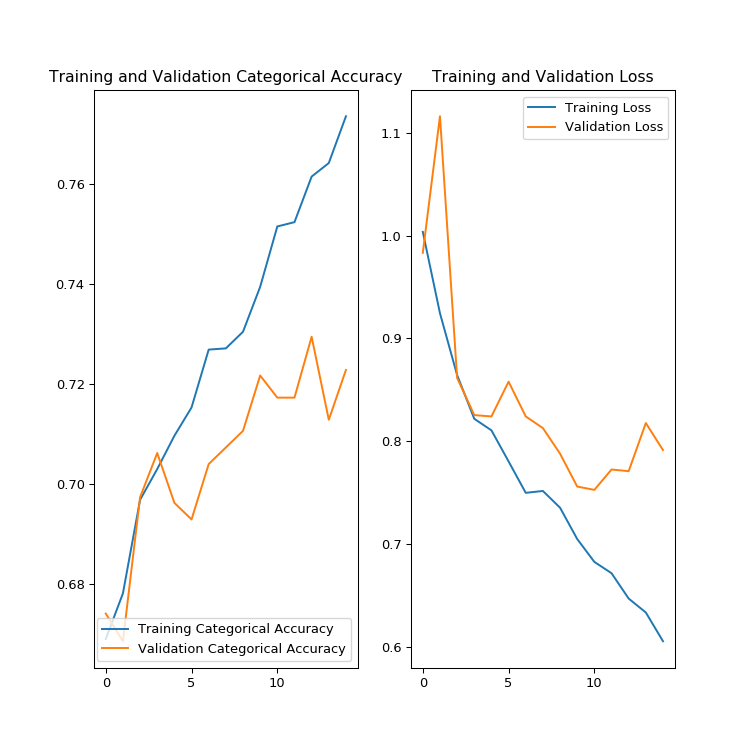

In [147]:
cat_acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, cat_acc, label='Training Categorical Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Categorical Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Categorical Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Report 

In [22]:
y_pred_loss = cnn_loss.predict(test_set)
y_pred_acc = cnn_acc.predict(test_set)

**Extracting Image Data and Target Labels of test_set as `nparray`**

In [23]:
X_test = np.concatenate([test_set.next()[0] for i in range(test_set.__len__())])
y_test = np.concatenate([test_set.next()[1] for i in range(test_set.__len__())])
print("Test - Images Shape: ", X_test.shape, '\n')
print("Test - Labels Shape: ", y_test.shape)

Test - Images Shape:  (1002, 300, 400, 3) 

Test - Labels Shape:  (1002, 7)


In [32]:
from sklearn.metrics import classification_report
print("Min-Loss CNN: \n")
report = classification_report(
    y_test.argmax(axis=1),
    y_pred_loss.argmax(axis=1),
    target_names=['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc', 'mel'])
print(report)

Min-Loss CNN: 

              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        33
         bcc       0.00      0.00      0.00        51
         bkl       0.08      0.06      0.07       110
          df       0.00      0.00      0.00        12
          nv       0.11      0.05      0.07       111
        vasc       0.66      0.81      0.73       671
         mel       0.00      0.00      0.00        14

    accuracy                           0.55      1002
   macro avg       0.12      0.13      0.12      1002
weighted avg       0.46      0.55      0.50      1002



In [33]:
from sklearn.metrics import classification_report
print("Max-Acc CNN: \n")
report = classification_report(
    y_test.argmax(axis=1),
    y_pred_acc.argmax(axis=1),
    target_names=['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc', 'mel'])
print(report)

Max-Acc CNN: 

              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        33
         bcc       0.05      0.06      0.05        51
         bkl       0.13      0.13      0.13       110
          df       0.00      0.00      0.00        12
          nv       0.12      0.05      0.07       111
        vasc       0.65      0.72      0.69       671
         mel       0.00      0.00      0.00        14

    accuracy                           0.50      1002
   macro avg       0.14      0.14      0.13      1002
weighted avg       0.47      0.50      0.48      1002



# Learning - Augmenting Data for Imbalanced Classes 

## Data Augmentation 

In [30]:
def augment(dirs, n):
    # dirs: directory of the class for which data needs to be augmented
    # n: times the data needs to be oversampled

    datagen = ImageDataGenerator()
    dirs1 = dirs+'*'
    for i in tqdm(range(n)):
        for imgs in glob.glob(dirs1):
            img = load_img(imgs)
            img = img_to_array(img)
            z = np.random.uniform(0.3,0.65)
            s = np.random.uniform(0, 45)
            c = np.random.uniform(0, 30)
            generate = datagen.apply_transform(x=img,
                                               transform_parameters={
                                                   'zx':
                                                   z,
                                                   'zy':
                                                   z,
                                                   'theta':
                                                   s,
                                                   'flip_horizontal':
                                                   random.choice([0, 1]),
                                                   'flip_vertical':
                                                   random.choice([0, 1]),
                                                   'channel_shift_intensity': c
                                               })
            save_dir = dirs[0:len(dirs)-1] + '_aug/' + imgs[-16:-4] + '_aug' + str(i) + '.jpg'
            save_img(save_dir, generate)

In [30]:
np.random.uniform(0, 20)

16.026005837391118

In [31]:
augment('D:/Storage/Datasets/skin_cancer_dataverse/dataset/train_images/df/', 11)
augment('D:/Storage/Datasets/skin_cancer_dataverse/dataset/train_images/vasc/', 10)
augment('D:/Storage/Datasets/skin_cancer_dataverse/dataset/train_images/akiec/', 5)
augment('D:/Storage/Datasets/skin_cancer_dataverse/dataset/train_images/bcc/', 2)

## Setting DataGenerators 

In [40]:
train_datagen = ImageDataGenerator(rescale=1. / 255, rotation_range=45, zoom_range=[0.6,0.7])
training_set = train_datagen.flow_from_directory(
    'D:/Storage/Datasets/skin_cancer_dataverse/dataset/train_images/',
    target_size=(224, 224),
    batch_size=8,
    color_mode='rgb',
    class_mode='categorical',
    subset='training')

Found 12438 images belonging to 7 classes.


In [41]:
valid_datagen = ImageDataGenerator(rescale=1. / 255, rotation_range=45, zoom_range=[0.6,0.7])
validating_set = valid_datagen.flow_from_directory(
    'D:/Storage/Datasets/skin_cancer_dataverse/dataset/valid_images/',
    target_size=(224, 224),
    batch_size=8,
    color_mode='rgb',
    class_mode='categorical')

Found 902 images belonging to 7 classes.


In [42]:
test_datagen = ImageDataGenerator(rescale=1. / 255)
test_set = test_datagen.flow_from_directory(
    'D:/Storage/Datasets/skin_cancer_dataverse/dataset/test_images/',
    target_size=(224, 224),
    batch_size=1,
    color_mode='rgb',
    class_mode='categorical')

Found 1002 images belonging to 7 classes.


## Setting DenseNet-121 Architecture

In [7]:
from tensorflow.keras.applications.densenet import DenseNet121

In [8]:
densenet_121 = DenseNet121(include_top=False,input_shape=[224,224,3])
densenet_121.trainable=True
densenet_121.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [9]:
output_layer = densenet_121.get_layer('relu')
print('output layer shape={}'.format(output_layer.output_shape))
out=output_layer.output

output layer shape=(None, 7, 7, 1024)


## Training -  Using DenseNet-121 Architecture

In [195]:
x = tf.keras.layers.MaxPooling2D(3,3)(out)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Flatten()(x)
# x = tf.keras.layers.Dense(1500, activation='relu')(x)
# x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(500, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)

output = tf.keras.layers.Dense(7, activation='softmax')(x)

model = tf.keras.models.Model(densenet_121.input,output)
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
_______________________________________________________________________________________

In [198]:
model.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['categorical_accuracy'])

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                      mode='min',
                                      verbose=1,
                                      patience=11,
                                      restore_best_weights=True)

filepath_acc = 'best_model_acc_2.hdf5'
checkpoint_acc = ModelCheckpoint(filepath_acc,
                                 monitor='val_categorical_accuracy',
                                 verbose=1,
                                 save_best_only=True,
                                 mode='max')

filepath_loss = 'best_model_loss_2.hdf5'
checkpoint_loss = ModelCheckpoint(filepath_loss,
                                  monitor='val_loss',
                                  verbose=1,
                                  save_best_only=True,
                                  mode='min')

# learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
#                                             patience=3, 
#                                             verbose=1, 
#                                             factor=0.5, 
#                                             min_lr=0.00001)

In [12]:
history = model.fit(x=training_set,
                  validation_data=validating_set,
                  epochs=50,
                  callbacks=[es, checkpoint_loss, checkpoint_acc])

Epoch 1/50
1555/1555 [==============================] - ETA: 0s - loss: 1.3704 - categorical_accuracy: 0.5708
Epoch 00001: val_loss improved from inf to 1.30166, saving model to best_model_loss_2.hdf5

Epoch 00001: val_categorical_accuracy improved from -inf to 0.68071, saving model to best_model_acc_2.hdf5
1555/1555 [==============================] - 774s 498ms/step - loss: 1.3704 - categorical_accuracy: 0.5708 - val_loss: 1.3017 - val_categorical_accuracy: 0.6807
Epoch 2/50
1555/1555 [==============================] - ETA: 0s - loss: 1.0002 - categorical_accuracy: 0.6318
Epoch 00002: val_loss did not improve from 1.30166

Epoch 00002: val_categorical_accuracy did not improve from 0.68071
1555/1555 [==============================] - 811s 521ms/step - loss: 1.0002 - categorical_accuracy: 0.6318 - val_loss: 1.5019 - val_categorical_accuracy: 0.5710
Epoch 3/50
1555/1555 [==============================] - ETA: 0s - loss: 0.8803 - categorical_accuracy: 0.6660
Epoch 00003: val_loss did not 

Epoch 20/50
1555/1555 [==============================] - ETA: 0s - loss: 0.3661 - categorical_accuracy: 0.8665
Epoch 00020: val_loss did not improve from 0.58992

Epoch 00020: val_categorical_accuracy did not improve from 0.80820
1555/1555 [==============================] - 824s 530ms/step - loss: 0.3661 - categorical_accuracy: 0.8665 - val_loss: 0.7372 - val_categorical_accuracy: 0.7694
Epoch 21/50
1555/1555 [==============================] - ETA: 0s - loss: 0.3481 - categorical_accuracy: 0.8716
Epoch 00021: val_loss did not improve from 0.58992

Epoch 00021: val_categorical_accuracy did not improve from 0.80820
1555/1555 [==============================] - 832s 535ms/step - loss: 0.3481 - categorical_accuracy: 0.8716 - val_loss: 0.6376 - val_categorical_accuracy: 0.7949
Epoch 22/50
1555/1555 [==============================] - ETA: 0s - loss: 0.3342 - categorical_accuracy: 0.8787
Epoch 00022: val_loss did not improve from 0.58992

Epoch 00022: val_categorical_accuracy did not improve f

In [13]:
model_loss = load_model('./best_model_loss_2.hdf5')
model_acc = load_model('./best_model_acc_2.hdf5')

## Evaluation 

**Testing Data Evaluation**

In [14]:
[loss, cat_acc] = model_loss.evaluate(test_set)
print(loss, cat_acc*100)

1002/1002 [==============================] - 32s 32ms/step - loss: 0.5712 - categorical_accuracy: 0.7954
0.5712476372718811 79.54092025756836


In [15]:
[loss, cat_acc] = model_acc.evaluate(test_set)
print(loss, cat_acc*100)

1002/1002 [==============================] - 33s 33ms/step - loss: 0.6029 - categorical_accuracy: 0.7854
0.602870523929596 78.54291200637817


### Graphs 

<IPython.core.display.Javascript object>


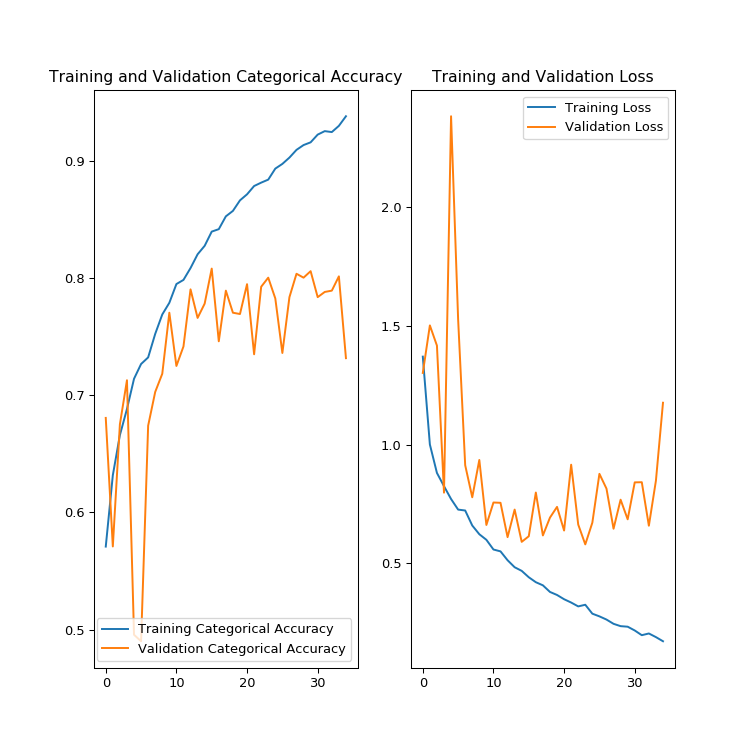

In [31]:
cat_acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['val_loss']))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, cat_acc, label='Training Categorical Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Categorical Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Categorical Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Report 

In [17]:
y_pred_loss = model_loss.predict(test_set)
y_pred_acc = model_acc.predict(test_set)

**Extracting Image Data and Target Labels of test_set as `nparray`**

In [18]:
X_test = np.concatenate([test_set.next()[0] for i in range(test_set.__len__())])
y_test = np.concatenate([test_set.next()[1] for i in range(test_set.__len__())])
print("Test - Images Shape: ", X_test.shape, '\n')
print("Test - Labels Shape: ", y_test.shape)

Test - Images Shape:  (1002, 224, 224, 3) 

Test - Labels Shape:  (1002, 7)


In [19]:
from sklearn.metrics import classification_report
print("Min-Loss CNN: \n")
report = classification_report(
    y_test.argmax(axis=1),
    y_pred_loss.argmax(axis=1),
    target_names=['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'])
print(report)

Min-Loss CNN: 

              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        33
         bcc       0.06      0.04      0.05        51
         bkl       0.05      0.05      0.05       110
          df       0.06      0.08      0.07        12
         mel       0.05      0.02      0.03       111
          nv       0.67      0.77      0.71       671
        vasc       0.00      0.00      0.00        14

    accuracy                           0.52      1002
   macro avg       0.13      0.14      0.13      1002
weighted avg       0.46      0.52      0.49      1002



In [20]:
from sklearn.metrics import classification_report
print("Max-Acc CNN: \n")
report = classification_report(
    y_test.argmax(axis=1),
    y_pred_acc.argmax(axis=1),
    target_names=['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'])
print(report)

Max-Acc CNN: 

              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        33
         bcc       0.00      0.00      0.00        51
         bkl       0.10      0.07      0.08       110
          df       0.00      0.00      0.00        12
         mel       0.12      0.11      0.11       111
          nv       0.67      0.74      0.70       671
        vasc       0.00      0.00      0.00        14

    accuracy                           0.51      1002
   macro avg       0.13      0.13      0.13      1002
weighted avg       0.47      0.51      0.49      1002



In [26]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

<IPython.core.display.Javascript object>


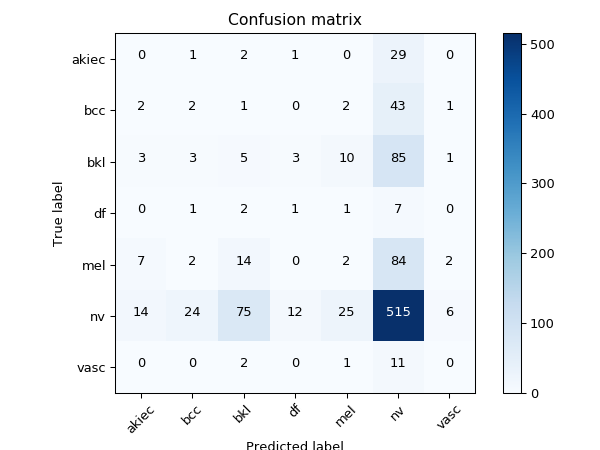

In [34]:
confusion_mtx = confusion_matrix(y_test.argmax(axis=1), y_pred_loss.argmax(axis=1))
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
plot_confusion_matrix(confusion_mtx, plot_labels)

<IPython.core.display.Javascript object>


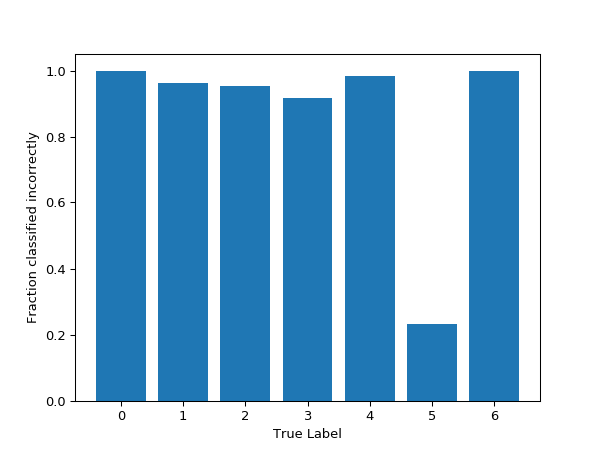

Text(0,0.5,'Fraction classified incorrectly')

In [35]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')

## Training -  Focal Loss for Class Imbalance

In [40]:
x = tf.keras.layers.MaxPooling2D(3,3)(out)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1500, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(500, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)

output = tf.keras.layers.Dense(7, activation='softmax')(x)

model = tf.keras.models.Model(densenet_121.input,output)
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
_______________________________________________________________________________________

In [52]:
model.compile(optimizer='adam',
            loss=tfa.losses.SigmoidFocalCrossEntropy(),
            metrics=['categorical_accuracy'])

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                      mode='min',
                                      verbose=1,
                                      patience=12,
                                      restore_best_weights=True)

filepath_acc = 'best_model_acc_3.hdf5'
checkpoint_acc = ModelCheckpoint(filepath_acc,
                                 monitor='val_categorical_accuracy',
                                 verbose=1,
                                 save_best_only=True,
                                 mode='max')

filepath_loss = 'best_model_loss_3.hdf5'
checkpoint_loss = ModelCheckpoint(filepath_loss,
                                  monitor='val_loss',
                                  verbose=1,
                                  save_best_only=True,
                                  mode='min')

In [56]:
history = model.fit(x=training_set,
                  validation_data=validating_set,
                  epochs=60,
                  callbacks=[es, checkpoint_loss, checkpoint_acc])

Epoch 1/60
1555/1555 [==============================] - ETA: 0s - loss: 13.3700 - categorical_accuracy: 0.1278
Epoch 00001: val_loss improved from inf to 14.78368, saving model to best_model_loss_3.hdf5

Epoch 00001: val_categorical_accuracy improved from -inf to 0.03326, saving model to best_model_acc_3.hdf5
1555/1555 [==============================] - 850s 547ms/step - loss: 13.3700 - categorical_accuracy: 0.1278 - val_loss: 14.7837 - val_categorical_accuracy: 0.0333
Epoch 2/60
1555/1555 [==============================] - ETA: 0s - loss: 13.4004 - categorical_accuracy: 0.1274
Epoch 00002: val_loss improved from 14.78368 to 14.78368, saving model to best_model_loss_3.hdf5

Epoch 00002: val_categorical_accuracy did not improve from 0.03326
1555/1555 [==============================] - 848s 545ms/step - loss: 13.4004 - categorical_accuracy: 0.1274 - val_loss: 14.7837 - val_categorical_accuracy: 0.0333
Epoch 3/60
1555/1555 [==============================] - ETA: 0s - loss: 13.4007 - categ

KeyboardInterrupt: 

In [13]:
model_loss = load_model('./best_model_loss_3.hdf5')
model_acc = load_model('./best_model_acc_3.hdf5')

***Loss plateaus out quickly at val_loss = 14.7837 for another epochs: 2-9 indicating no sign of improvement***

Try callback to modify LR for plateau of Min Function

## Using Learning Rate Annealing

In [10]:
x = tf.keras.layers.MaxPooling2D(3,3)(out)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Flatten()(x)
# x = tf.keras.layers.Dense(1500, activation='relu')(x)
# x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(500, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)

output = tf.keras.layers.Dense(7, activation='softmax')(x)

model = tf.keras.models.Model(densenet_121.input,output)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
_______________________________________________________________________________________

In [11]:
model.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['categorical_accuracy'])

filepath_acc = 'best_model_acc_lra.hdf5'
checkpoint_acc = ModelCheckpoint(filepath_acc,
                                 monitor='val_categorical_accuracy',
                                 verbose=1,
                                 save_best_only=True,
                                 mode='max')

filepath_loss = 'best_model_loss_lra.hdf5'
checkpoint_loss = ModelCheckpoint(filepath_loss,
                                  monitor='val_loss',
                                  verbose=1,
                                  save_best_only=True,
                                  mode='min')

learning_rate_reduction = ReduceLROnPlateau(monitor='val_categorical_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [12]:
history = model.fit(x=training_set,
                  validation_data=validating_set,
                  epochs=,
                  callbacks=[learning_rate_reduction, checkpoint_loss, checkpoint_acc])

Epoch 1/50
1555/1555 [==============================] - ETA: 0s - loss: 1.2730 - categorical_accuracy: 0.6027
Epoch 00001: val_loss improved from inf to 0.80317, saving model to best_model_loss_lra.hdf5

Epoch 00001: val_categorical_accuracy improved from -inf to 0.72395, saving model to best_model_acc_lra.hdf5
1555/1555 [==============================] - 825s 531ms/step - loss: 1.2730 - categorical_accuracy: 0.6027 - val_loss: 0.8032 - val_categorical_accuracy: 0.7239
Epoch 2/50
1555/1555 [==============================] - ETA: 0s - loss: 0.8831 - categorical_accuracy: 0.6693
Epoch 00002: val_loss improved from 0.80317 to 0.71013, saving model to best_model_loss_lra.hdf5

Epoch 00002: val_categorical_accuracy did not improve from 0.72395
1555/1555 [==============================] - 811s 522ms/step - loss: 0.8831 - categorical_accuracy: 0.6693 - val_loss: 0.7101 - val_categorical_accuracy: 0.7206
Epoch 3/50
1555/1555 [==============================] - ETA: 0s - loss: 0.7904 - categoric

1555/1555 [==============================] - 842s 542ms/step - loss: 0.1352 - categorical_accuracy: 0.9501 - val_loss: 0.6416 - val_categorical_accuracy: 0.8337
Epoch 20/50
1555/1555 [==============================] - ETA: 0s - loss: 0.1103 - categorical_accuracy: 0.9590
Epoch 00020: val_loss did not improve from 0.56291

Epoch 00020: val_categorical_accuracy did not improve from 0.83370
1555/1555 [==============================] - 838s 539ms/step - loss: 0.1103 - categorical_accuracy: 0.9590 - val_loss: 1.3668 - val_categorical_accuracy: 0.6907
Epoch 21/50
1555/1555 [==============================] - ETA: 0s - loss: 0.0914 - categorical_accuracy: 0.9677
Epoch 00021: val_loss did not improve from 0.56291

Epoch 00021: val_categorical_accuracy did not improve from 0.83370
1555/1555 [==============================] - 839s 539ms/step - loss: 0.0914 - categorical_accuracy: 0.9677 - val_loss: 0.7399 - val_categorical_accuracy: 0.8304
Epoch 22/50
1555/1555 [==============================] - 

In [33]:
model_loss = load_model('./best_model_loss_lra.hdf5')
model_acc = load_model('./best_model_acc_lra.hdf5')

## Evaluation 

**Testing Data Evaluation**

In [14]:
[loss, cat_acc] = model_loss.evaluate(test_set)
print(loss, cat_acc*100)

1002/1002 [==============================] - 36s 36ms/step - loss: 0.5876 - categorical_accuracy: 0.8064
0.5876261591911316 80.63872456550598


In [15]:
[loss, cat_acc] = model_acc.evaluate(test_set)
print(loss, cat_acc*100)

1002/1002 [==============================] - 33s 33ms/step - loss: 1.0285 - categorical_accuracy: 0.8393
1.0285346508026123 83.93213748931885


### Graphs 

<IPython.core.display.Javascript object>


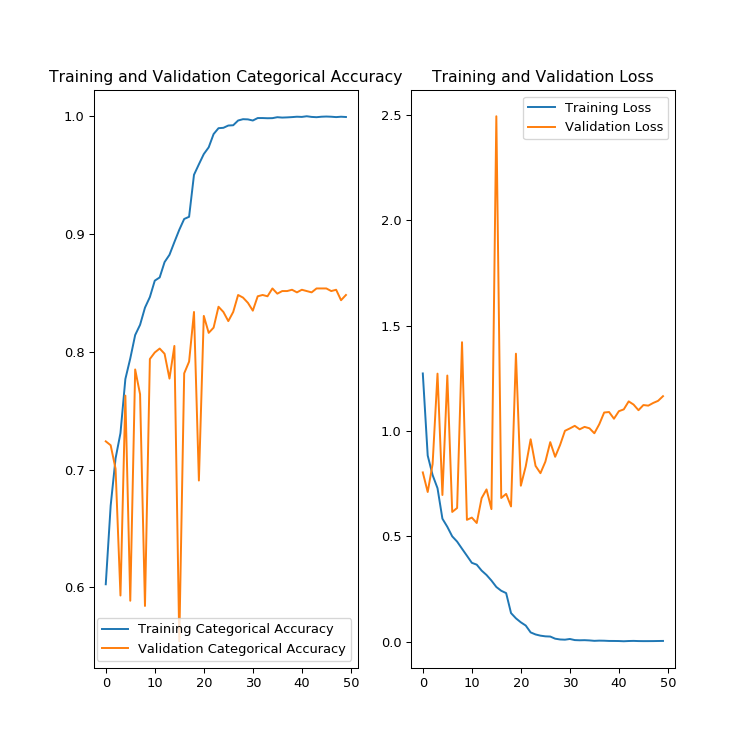

In [26]:
cat_acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['val_loss']))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, cat_acc, label='Training Categorical Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Categorical Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Categorical Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Report 

In [17]:
y_pred_loss = model_loss.predict(test_set)
y_pred_acc = model_acc.predict(test_set)

**Extracting Image Data and Target Labels of test_set as `nparray`**

In [18]:
X_test = np.concatenate([test_set.next()[0] for i in range(test_set.__len__())])
y_test = np.concatenate([test_set.next()[1] for i in range(test_set.__len__())])
print("Test - Images Shape: ", X_test.shape, '\n')
print("Test - Labels Shape: ", y_test.shape)

Test - Images Shape:  (1002, 224, 224, 3) 

Test - Labels Shape:  (1002, 7)


In [19]:
from sklearn.metrics import classification_report
print("Min-Loss CNN: \n")
report = classification_report(
    y_test.argmax(axis=1),
    y_pred_loss.argmax(axis=1),
    target_names=['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'])
print(report)

Min-Loss CNN: 

              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        33
         bcc       0.04      0.04      0.04        51
         bkl       0.14      0.12      0.13       110
          df       0.20      0.17      0.18        12
         mel       0.15      0.14      0.14       111
          nv       0.67      0.72      0.69       671
        vasc       0.00      0.00      0.00        14

    accuracy                           0.51      1002
   macro avg       0.17      0.17      0.17      1002
weighted avg       0.48      0.51      0.50      1002



In [20]:
from sklearn.metrics import classification_report
print("Max-Acc CNN: \n")
report = classification_report(
    y_test.argmax(axis=1),
    y_pred_acc.argmax(axis=1),
    target_names=['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'])
print(report)

Max-Acc CNN: 

              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        33
         bcc       0.02      0.02      0.02        51
         bkl       0.08      0.07      0.08       110
          df       0.09      0.08      0.09        12
         mel       0.09      0.07      0.08       111
          nv       0.66      0.70      0.68       671
        vasc       0.00      0.00      0.00        14

    accuracy                           0.49      1002
   macro avg       0.13      0.14      0.13      1002
weighted avg       0.47      0.49      0.48      1002



In [66]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

<IPython.core.display.Javascript object>


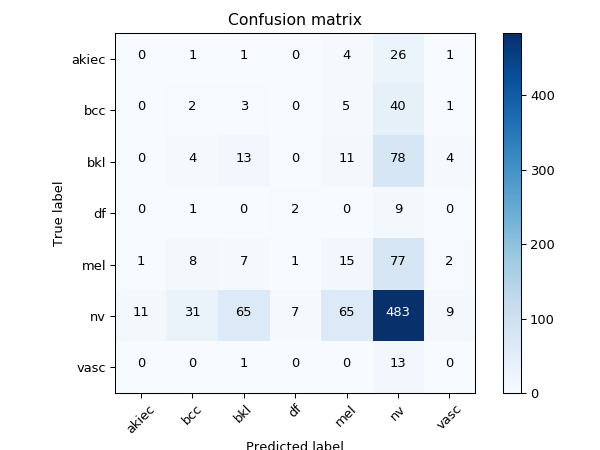

In [24]:
confusion_mtx = confusion_matrix(y_test.argmax(axis=1), y_pred_loss.argmax(axis=1))
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
plot_confusion_matrix(confusion_mtx, plot_labels)

<IPython.core.display.Javascript object>


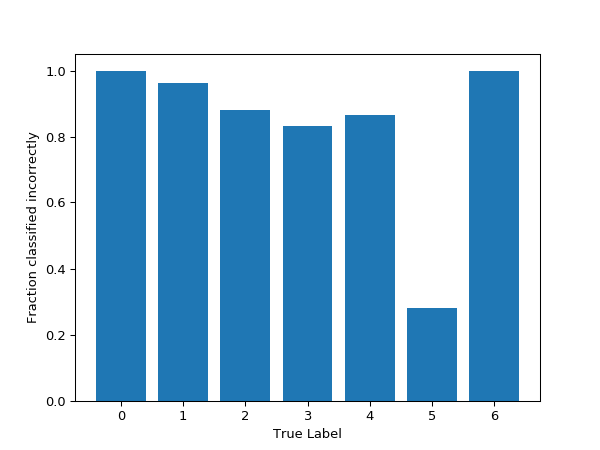

Text(0,0.5,'Fraction classified incorrectly')

In [25]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')

## Training Base Model with L.R. Annealing 

In [43]:
cnn = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[224,224,3]),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=3),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=3),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=3),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=500, activation='relu'),
    tf.keras.layers.Dense(units=7, activation='softmax')
])

cnn.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 220, 220, 32)      9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 73, 73, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 71, 71, 32)        9248      
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 69, 69, 32)        9248      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 23, 23, 32)       

In [44]:
cnn.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['categorical_accuracy'])

filepath_acc = 'best_model_acc_baselra.hdf5'
checkpoint_acc = ModelCheckpoint(filepath_acc,
                                 monitor='val_categorical_accuracy',
                                 verbose=1,
                                 save_best_only=True,
                                 mode='max')

filepath_loss = 'best_model_loss_baselra.hdf5'
checkpoint_loss = ModelCheckpoint(filepath_loss,
                                  monitor='val_loss',
                                  verbose=1,
                                  save_best_only=True,
                                  mode='min')

learning_rate_reduction = ReduceLROnPlateau(monitor='val_categorical_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [45]:
history = cnn.fit(x=training_set,
                  validation_data=validating_set,
                  epochs=50,
                  callbacks=[learning_rate_reduction, checkpoint_loss, checkpoint_acc])

Epoch 1/50
1555/1555 [==============================] - ETA: 0s - loss: 1.4406 - categorical_accuracy: 0.5117
Epoch 00001: val_loss improved from inf to 1.09695, saving model to best_model_loss_baselra.hdf5

Epoch 00001: val_categorical_accuracy improved from -inf to 0.64191, saving model to best_model_acc_baselra.hdf5
1555/1555 [==============================] - 291s 187ms/step - loss: 1.4406 - categorical_accuracy: 0.5117 - val_loss: 1.0969 - val_categorical_accuracy: 0.6419
Epoch 2/50
1555/1555 [==============================] - ETA: 0s - loss: 1.2003 - categorical_accuracy: 0.5784
Epoch 00002: val_loss improved from 1.09695 to 1.06678, saving model to best_model_loss_baselra.hdf5

Epoch 00002: val_categorical_accuracy improved from 0.64191 to 0.66962, saving model to best_model_acc_baselra.hdf5
1555/1555 [==============================] - 287s 185ms/step - loss: 1.2003 - categorical_accuracy: 0.5784 - val_loss: 1.0668 - val_categorical_accuracy: 0.6696
Epoch 3/50
1555/1555 [=======

KeyboardInterrupt: 

In [18]:
cnn_loss = load_model('./best_model_loss_baselra.hdf5')
cnn_acc = load_model('./best_model_acc_baselra.hdf5')

**Over fitting Again, No improvement form previous experiments** 

# Exploring Patient Metadata   

In [91]:
meta = pd.read_csv('D:/Storage/Datasets/skin_cancer_dataverse/HAM10000_metadata.csv')
meta['sum'] = pd.Series(np.ones(shape=(len(meta))))
meta.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,sum
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,1.0
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,1.0
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,1.0
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,1.0
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,1.0


## Viz 

In [141]:
a = meta.groupby(['sex', 'dx'])['sum'].sum()
a = pd.DataFrame(a)
a.reset_index(inplace=True)
a

,sex,dx,sum
0,female,akiec,106.0
1,female,bcc,197.0
2,female,bkl,463.0
3,female,df,52.0
4,female,mel,424.0
5,female,nv,3237.0
6,female,vasc,73.0
7,male,akiec,221.0
8,male,bcc,317.0
9,male,bkl,626.0


In [101]:
fig = px.scatter_matrix(meta, dimensions=['age', 'sex', 'localization'], color='dx')
fig.show()

In [100]:
fig = px.scatter_3d(meta, x="age", y="sex", z="localization", color='dx')
fig.show()

### Age 

In [120]:
temp_list=[]
names=list(meta['dx'].value_counts().to_frame().reset_index()['index'])

In [121]:
names

['nv', 'mel', 'bkl', 'bcc', 'akiec', 'vasc', 'df']

In [122]:
for i in names:
    temp_df=meta[meta['dx']==i]['age']
    temp_list.append(temp_df)
final_arr=np.array(temp_list)

In [123]:
fig = go.Figure()
for data_line,n in zip(final_arr,names):
    fig.add_trace(go.Violin(x=data_line,name=n))

fig.update_traces(orientation='h', side='positive', width=2, points=False)
fig.update_layout(title="Age vs Disease",xaxis_showgrid=False, xaxis_zeroline=True,height=800)
fig.show()

### Age & Sex 

In [148]:
meta['sex'].value_counts()

male       5406
female     4552
unknown      57
Name: sex, dtype: int64

In [147]:
meta['male_age'] = meta.apply(lambda x: x['age'] if x['sex']=='male' else None, axis=1)
meta['female_age'] = meta.apply(lambda x: x['age'] if x['sex']=='female' else None, axis=1)
meta

,lesion_id,image_id,dx,dx_type,age,sex,localization,sum,male_age,female_age
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,1.0,80.0,NaN
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,1.0,80.0,NaN
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,1.0,80.0,NaN
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,1.0,80.0,NaN
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,1.0,75.0,NaN
...,...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,1.0,40.0,NaN
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,1.0,40.0,NaN
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,1.0,40.0,NaN
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,1.0,80.0,NaN


<IPython.core.display.Javascript object>


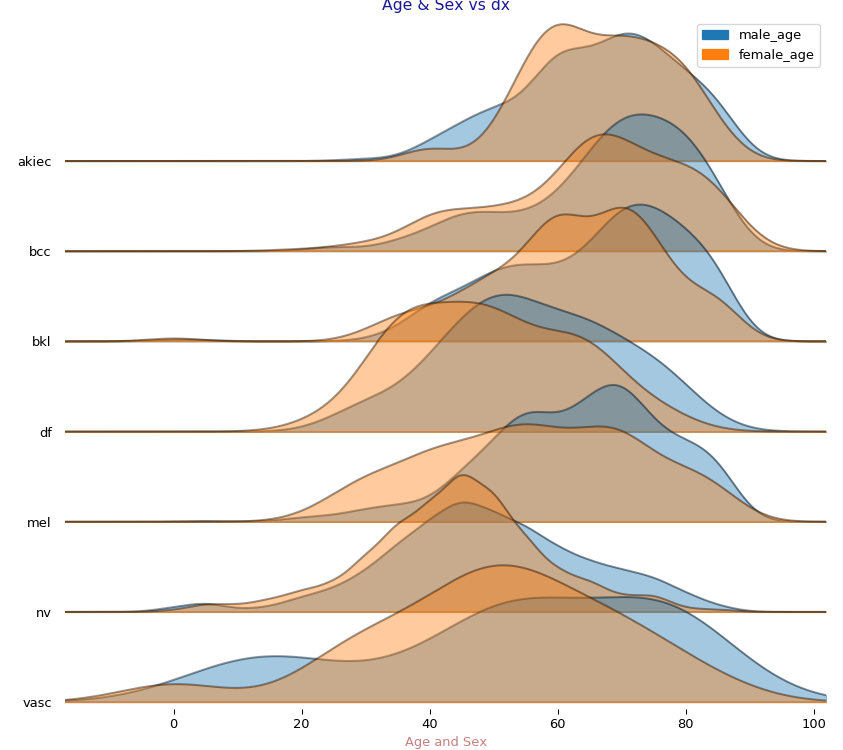

<function matplotlib.pyplot.show(*args, **kw)>

In [166]:
fig = joypy.joyplot(
    meta,
    column=['male_age', 'female_age'],
    by='dx',
    ylim='own',
    figsize=(9, 8),
    legend=True,
    alpha=0.4)

# Decoration
plt.title('Age & Sex vs dx',
          color='darkblue',
          alpha=0.9)
plt.rc("font", size=10)
plt.xlabel('Age and Sex', color='darkred', alpha=0.5)
plt.ylabel('dx',color='darkblue', alpha=0.9)

plt.show

### Localization 

In [171]:
a = meta.groupby(['localization', 'dx'])['sum'].sum().to_frame()

In [181]:
a.reset_index(inplace=True)
a

,localization,dx,sum
0,abdomen,akiec,5.0
1,abdomen,bcc,18.0
2,abdomen,bkl,42.0
3,abdomen,df,4.0
4,abdomen,mel,66.0
5,abdomen,nv,860.0
6,abdomen,vasc,27.0
7,acral,nv,7.0
8,back,akiec,29.0
9,back,bcc,186.0


In [190]:
l=list()
for i in a.dx.unique():
    fig = px.bar(a[a['dx']==i], x='localization', y='sum', title=i)
    l.append(fig)
for i in range(len(l)):
    l[i].show()

# Using Patient Metadata for Classification 

## Dataset Creation 

### Extracting P(Class / Image Tensors) 

In [9]:
model = load_model('./best_model_acc_lra.hdf5')

In [47]:
%whos

Variable                     Type                  Data/Info
------------------------------------------------------------
DenseNet121                  function              <function DenseNet121 at 0x0000010DD8230598>
ImageDataGenerator           type                  <class 'tensorflow.python<...>mage.ImageDataGenerator'>
ModelCheckpoint              type                  <class 'tensorflow.python<...>llbacks.ModelCheckpoint'>
Path                         type                  <class 'pathlib.Path'>
ReduceLROnPlateau            type                  <class 'tensorflow.python<...>backs.ReduceLROnPlateau'>
SparseCategoricalFocalLoss   type                  <class 'focal_loss._categ<...>rseCategoricalFocalLoss'>
X_test                       ndarray               1002x224x224x3: 150829056 elems, type `float32`, 603316224 bytes (575.3671875 Mb)
array_to_img                 function              <function array_to_img at 0x0000010DD846CB70>
cat_acc                      list                 

In [4]:
def extract_img_array(id):
    s='D:/Storage/Datasets/skin_cancer_dataverse/HAM10000_images/' + id + '.jpg'
    img = load_img(s, target_size=(224,224))
    arr = img_to_array(img)
    arr = np.divide(arr, 255)
    return arr

In [5]:
meta = pd.read_csv('D:/Storage/Datasets/skin_cancer_dataverse/HAM10000_metadata.csv')
meta['images'] = meta.image_id.swifter.set_npartitions(8).apply(lambda x: extract_img_array(x))

In [8]:
meta.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,images
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,"[[[0.73333335, 0.59607846, 0.7607843], [0.7450..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,"[[[0.09019608, 0.047058824, 0.078431375], [0.0..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,"[[[0.7254902, 0.49411765, 0.5176471], [0.73725..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,"[[[0.09019608, 0.043137256, 0.05882353], [0.09..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,"[[[0.49411765, 0.32941177, 0.41568628], [0.521..."


In [7]:
X = tf.data.Dataset.from_tensor_slices(meta['images'].values.tolist())
X = X.batch(1)

In [10]:
pred = model.predict(X)

**Save the `pred` ndarray for later use**

In [12]:
np.save('D:/Storage/Datasets/skin_cancer_dataverse/img_pred.npy', pred)

In [4]:
pred = np.load('D:/Storage/Datasets/skin_cancer_dataverse/img_pred.npy')

### Adding other features

In [16]:
X = pd.concat([pd.DataFrame(pred), meta[['age', 'sex', 'localization']]], axis=1)
X = pd.get_dummies(X, columns = ['localization', 'sex'], drop_first=True)
X.head()

,0,1,2,3,4,5,6,age,localization_acral,localization_back,...,localization_genital,localization_hand,localization_lower extremity,localization_neck,localization_scalp,localization_trunk,localization_unknown,localization_upper extremity,sex_male,sex_unknown
0,0.001232,4.000391e-09,0.997687,5.042182e-10,1.080162e-03,1.010611e-08,1.286036e-15,80.0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,0.000034,4.365303e-09,0.999720,4.300153e-08,2.389056e-04,7.322486e-06,5.768988e-12,80.0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,0.000007,4.397024e-09,0.999989,2.919900e-10,3.923295e-06,3.219347e-07,1.882628e-13,80.0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,0.000012,1.718861e-08,0.999860,5.815709e-07,1.220837e-04,4.881174e-06,2.116676e-11,80.0,0,0,...,0,0,0,0,1,0,0,0,1,0
4,0.000012,1.188755e-10,0.999988,1.965652e-12,2.737877e-07,1.859566e-08,3.318140e-16,75.0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [51]:
y = meta.replace({'dx' : { 'bcc' : 0, 'bkl' : 1, 'df' : 2, 'mel' : 3, 'nv' : 4, 'vasc': 5, 'akiec': 6}})['dx']
y

0        1
1        1
2        1
3        1
4        1
        ..
10010    6
10011    6
10012    6
10013    6
10014    3
Name: dx, Length: 10015, dtype: int64

**Using the Prob values of each image belonging to every class of skin cancer lesion and the age, sex, localization data, we train a LGBM Classifier with the target as the Class of Skin Cancer Lesion. Its better to use a tree based classifier here due to the availability of Categorical Vars**

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=420, stratify=y)

In [53]:
print('Train:\n', y_train.value_counts(), '\n')
print('Test:\n', y_test.value_counts())

Train:
 4    5364
3     890
1     879
0     411
6     262
5     114
2      92
Name: dx, dtype: int64 

Test:
 4    1341
3     223
1     220
0     103
6      65
5      28
2      23
Name: dx, dtype: int64


## Training Using LGBM

In [54]:
params = {
    "objective": "multiclass",
    "num_class": 7,
    "num_leaves": 15,
    "max_depth": 3,
    "learning_rate": 0.1,
    #"bagging_fraction": 1,
    #"feature_fraction": 0.7,
    #"bagging_freq": 20,
    #"bagging_seed": 2018,
    "verbosity": -1,
    "num_threads":8
}
train_lgbm = lgb.Dataset(X_train, y_train)
test_lgbm = lgb.Dataset(X_test, y_test)

In [64]:
def train_lgb(train_lgbm, test_lgbm, params):
    evals_result = {}
    lgbmodel = lgb.train(params,
                         train_lgbm,
                         num_boost_round=500,
                         valid_sets=[train_lgbm, test_lgbm],
                         early_stopping_rounds=20,
                         verbose_eval=50,
                         evals_result=evals_result)
    lgb.plot_metric(evals_result,metric = 'multi_logloss')
    return lgbmodel

Training until validation scores don't improve for 20 rounds
[50]	training's multi_logloss: 0.0724944	valid_1's multi_logloss: 0.109841
Early stopping, best iteration is:
[57]	training's multi_logloss: 0.0676723	valid_1's multi_logloss: 0.109386


<IPython.core.display.Javascript object>


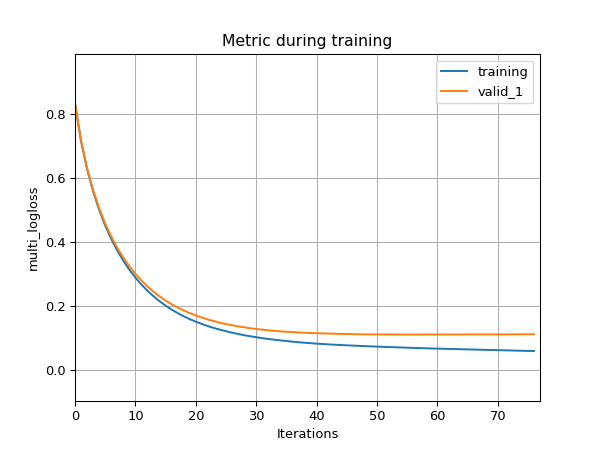

In [65]:
lgbmodel = train_lgb(train_lgbm, test_lgbm, params)

## Evaluation

In [58]:
#Evaluation Function
import pycm
def evaluate_model(Y_actual, Y_predicted):

    confusion_matrix_class = pycm.ConfusionMatrix(actual_vector=Y_actual,
                                                  predict_vector=Y_predicted)

    TPR = []
    PPV = []
    FPR = []
    FNR = []
    ACC = []
    F1 = []

    TPR.append(confusion_matrix_class.overall_stat['TPR Micro'])
    PPV.append(confusion_matrix_class.overall_stat['PPV Micro'])
    FPR.append(
        round((sum(confusion_matrix_class.FP.values()) /
               (sum(confusion_matrix_class.FP.values()) +
                sum(confusion_matrix_class.TN.values()))), 4))
    FNR.append(
        round((sum(confusion_matrix_class.FN.values()) /
               (sum(confusion_matrix_class.TP.values()) +
                sum(confusion_matrix_class.FN.values()))), 4))
    ACC.append(
        round((sum(confusion_matrix_class.TP.values()) +
               sum(confusion_matrix_class.TN.values())) /
              (sum(confusion_matrix_class.TP.values()) +
               sum(confusion_matrix_class.TN.values()) +
               sum(confusion_matrix_class.FP.values()) +
               sum(confusion_matrix_class.FN.values())), 4))
    F1.append(confusion_matrix_class.overall_stat['F1 Micro'])

    for i in confusion_matrix_class.classes:

        TPR.append(round(float(confusion_matrix_class.class_stat['TPR'][i]),
                         2))

        PPV.append(round(float(confusion_matrix_class.class_stat['PPV'][i]),
                         2))

        FPR.append(round(float(confusion_matrix_class.class_stat['FPR'][i]),
                         2))
        FNR.append(round(float(confusion_matrix_class.class_stat['FNR'][i]),
                         2))

        ACC.append(round(float(confusion_matrix_class.class_stat['ACC'][i]),
                         2))
        F1.append(round(float(confusion_matrix_class.class_stat['F1'][i]), 2))

    eval_df = pd.DataFrame()
    index = ['overall']
    index.extend(confusion_matrix_class.classes)
    eval_df['Recall'] = TPR
    eval_df['Precision'] = PPV
    eval_df['False_Positive_Rate'] = FPR
    eval_df['False_Negative_Rate'] = FNR
    eval_df['Accuracy'] = ACC
    eval_df['F1_Score'] = F1
    eval_df.index = index

    return (eval_df)

In [59]:
preds = lgbmodel.predict(X_train)
Y_pred = np.argmax(np.round(preds),axis = 1)
print(Y_pred.shape, y_train.shape)

from sklearn.metrics import classification_report,accuracy_score,f1_score
target_names = ["Class {}".format(i) for i in range(7)]
print("Training Scores:\n", classification_report(y_train, Y_pred, target_names=target_names))
evaluate_model(np.array(y_train), np.array(Y_pred))*100

(8012,) (8012,)
Training Scores:
               precision    recall  f1-score   support

     Class 0       0.82      0.99      0.89       411
     Class 1       0.97      0.94      0.95       879
     Class 2       0.99      0.93      0.96        92
     Class 3       0.98      0.92      0.95       890
     Class 4       0.99      0.99      0.99      5364
     Class 5       1.00      1.00      1.00       114
     Class 6       0.98      0.92      0.95       262

    accuracy                           0.98      8012
   macro avg       0.96      0.96      0.96      8012
weighted avg       0.98      0.98      0.98      8012



,Recall,Precision,False_Positive_Rate,False_Negative_Rate,Accuracy,F1_Score
overall,97.516226,97.516226,0.41,2.48,99.29,97.516226
0,99.000000,82.000000,1.00,1.00,99.00,89.000000
1,94.000000,97.000000,0.00,6.00,99.00,95.000000
2,93.000000,99.000000,0.00,7.00,100.00,96.000000
3,92.000000,98.000000,0.00,8.00,99.00,95.000000
4,99.000000,99.000000,2.00,1.00,99.00,99.000000
5,100.000000,100.000000,0.00,0.00,100.00,100.000000
6,92.000000,98.000000,0.00,8.00,100.00,95.000000


##### Evaluation on Testing 

In [61]:
preds = lgbmodel.predict(X_test)
Y_pred = np.argmax(np.round(preds),axis = 1)
print(Y_pred.shape, y_test.shape)

from sklearn.metrics import classification_report,accuracy_score,f1_score
target_names = ["Class {}".format(i) for i in range(7)]
print("Testing Scores:\n", classification_report(y_test, Y_pred, target_names=target_names))
evaluate_model(np.array(y_test), np.array(Y_pred))*100

(2003,) (2003,)
Testing Scores:
               precision    recall  f1-score   support

     Class 0       0.78      0.99      0.87       103
     Class 1       0.94      0.94      0.94       220
     Class 2       0.95      0.91      0.93        23
     Class 3       0.91      0.92      0.92       223
     Class 4       0.99      0.97      0.98      1341
     Class 5       0.97      1.00      0.98        28
     Class 6       0.98      0.91      0.94        65

    accuracy                           0.96      2003
   macro avg       0.93      0.95      0.94      2003
weighted avg       0.96      0.96      0.96      2003



,Recall,Precision,False_Positive_Rate,False_Negative_Rate,Accuracy,F1_Score
overall,96.105841,96.105841,0.65,3.89,98.89,96.105841
0,99.000000,78.000000,2.00,1.00,99.00,87.000000
1,94.000000,94.000000,1.00,6.00,99.00,94.000000
2,91.000000,95.000000,0.00,9.00,100.00,93.000000
3,92.000000,91.000000,1.00,8.00,98.00,92.000000
4,97.000000,99.000000,2.00,3.00,98.00,98.000000
5,100.000000,97.000000,0.00,0.00,100.00,98.000000
6,91.000000,98.000000,0.00,9.00,100.00,94.000000


<IPython.core.display.Javascript object>


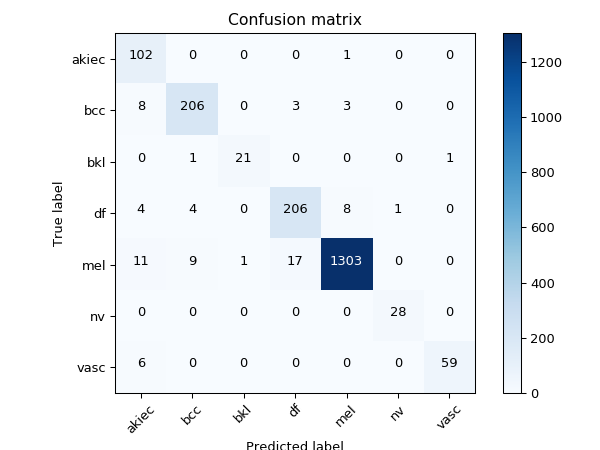

In [70]:
confusion_mtx = confusion_matrix(y_test, Y_pred)
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
plot_confusion_matrix(confusion_mtx, plot_labels)

# Conclusion 

**The scores for image classification using only the image tensors are as follows:** <br>
*Format of reporting scores: Training accuracy - Validation Accuracy - Testing Accuracy; F1 Score on Test Data, in %* <br>
- Base Model using 3 blocks of `Conv2D-Conv2D-MaxPool2D`: 76.16 - 73 - 71.75 ; 55 <br><br>
**After Augmenting low data classes:** <br>
1. Transfer Learning using `DenseNet-121`: 84 - 80.82 - 79.54; 52 <br>
2. Using `DenseNet-121` architecture and using Focal Loss for class imbalance neutralization: Loss plateaued in the vicinity of 13.5 in the first 10 epochs. <br>
3. Using `DenseNet-121`architecture using Learning Rate Annealing for optimum loss minimization: 99.9 - 85.36 - 83.93; 51 <br>
4. Base Model using 3 blocks of `Conv2D-Conv2D-MaxPool2D` and L.R. Annealing: Over-fitting <br><br>
**Using Model 3 and adding meta-data of the patients for better classification:** <br>
- `LightGBM`: 99.29 - 98.89; 96.10